In [1]:
# Import necessary libraries
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Additional libraries for confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [2]:

# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


In [3]:
# Set directory paths
dataset = "C:\\Users\\RoopaGanesh\\Downloads\\Cotton_data"
train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

In [9]:

# Batch size and number of classes
bs = 32
num_classes = len(os.listdir(valid_directory))  
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Mapping of indices to class names
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

5
{0: 'Aphids', 1: 'Bacterial blight', 2: 'Cotton Boll Rot', 3: 'Healthy', 4: 'Powdery mildew'}


In [10]:
# Size of Data
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

# Load pretrained AlexNet model
alexnet = models.alexnet(pretrained=True)

# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

# Change the final layer for transfer learning
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim=1))

# Define optimizer and loss function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters())


In [11]:

# Training and validation function
def train_and_validate(model, loss_criterion, optimizer, epochs=5):
    start = time.time()
    history = []
    all_preds = []
    all_labels = []

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        model.train()  # Set to training mode
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()

            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)

        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, Validation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s"
              .format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
    return model, history, all_preds, all_labels

In [12]:
# Define device and train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 5
trained_model, history, all_preds, all_labels = train_and_validate(alexnet.to(device), loss_func, optimizer, num_epochs)

# Save training history
torch.save(history, dataset+'_history.pt')

Epoch: 1/5
Epoch: 001, Training: Loss: 0.2378, Accuracy: 91.3462%, Validation: Loss: 0.1118, Accuracy: 96.4072%, Time: 110.8690s
Epoch: 2/5
Epoch: 002, Training: Loss: 0.0958, Accuracy: 96.7308%, Validation: Loss: 0.1002, Accuracy: 97.6048%, Time: 87.2616s
Epoch: 3/5
Epoch: 003, Training: Loss: 0.0757, Accuracy: 97.2837%, Validation: Loss: 0.1007, Accuracy: 97.6048%, Time: 91.9716s
Epoch: 4/5
Epoch: 004, Training: Loss: 0.0592, Accuracy: 98.0529%, Validation: Loss: 0.0796, Accuracy: 98.8024%, Time: 91.0691s
Epoch: 5/5
Epoch: 005, Training: Loss: 0.0539, Accuracy: 98.1010%, Validation: Loss: 0.0792, Accuracy: 98.2036%, Time: 88.6082s


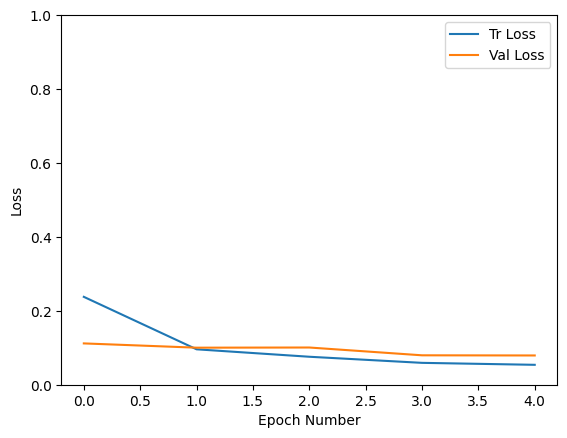

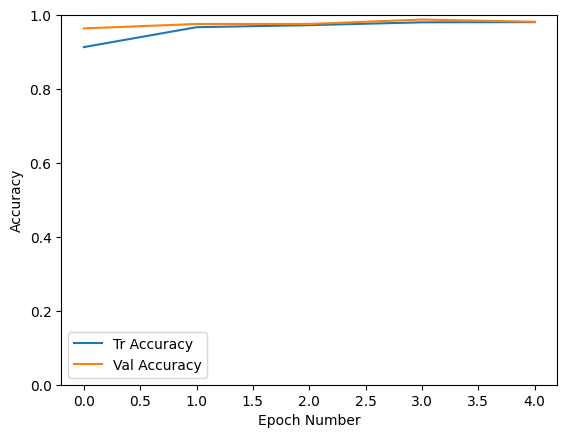

In [13]:
# Convert history to numpy array and plot loss and accuracy
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

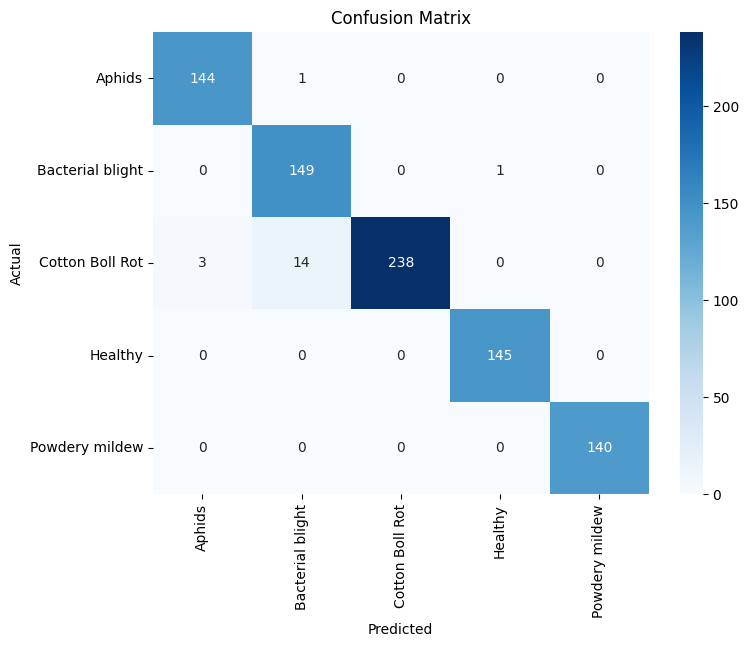

In [14]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=[idx_to_class[i] for i in range(num_classes)],
                     columns=[idx_to_class[i] for i in range(num_classes)])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Prediction on a single test image
def predict(model, test_image_name):
    transform = image_transforms['test']
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(5, dim=1)
        for i in range(5):
            print("Prediction", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

Prediction 1 : Aphids , Score:  0.99996483
Prediction 2 : Cotton Boll Rot , Score:  1.8412986e-05
Prediction 3 : Bacterial blight , Score:  7.758403e-06
Prediction 4 : Powdery mildew , Score:  7.710546e-06
Prediction 5 : Healthy , Score:  1.3445206e-06


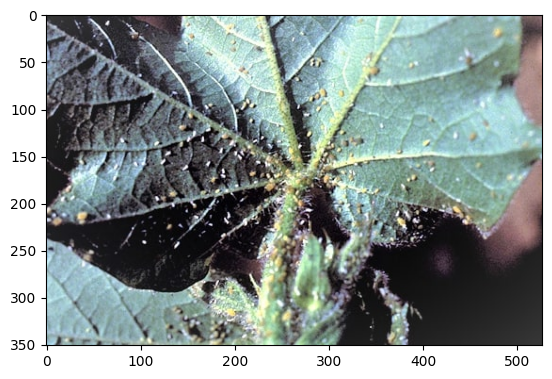

In [16]:
# Example prediction
predict(trained_model, "C:\\Users\\RoopaGanesh\\Downloads\\Cotton_data\\valid\\Aphids\\6.jpg")

In [ ]:
Insights:
The model performs well on most categories, with high accuracy for Healthy and Powdery mildew (no misclassifications).
There is some confusion between Cotton Boll Rot and Bacterial blight, with 14 instances of Cotton Boll Rot misclassified as Bacterial blight.
Aphids have a minor misclassification issue with Bacterial blight.
Overall, the model's performance is strong, but improvement may be needed to reduce confusion between similar categories, particularly between Cotton Boll Rot and Bacterial blight.